In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
import jenkspy
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from scipy.stats import pearsonr
import scipy
import prophet
import warnings
warnings.filterwarnings("ignore")
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.optimize import curve_fit
import matplotlib.colors as colors
import mapclassify
from libpysal.weights.contiguity import Queen
from libpysal import examples
import geopandas as gpd
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from scipy.interpolate import UnivariateSpline

/Users/carmen/anaconda3/envs/geo-env-new/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
font_path = '/Users/carmen/anaconda3/pkgs/r-rmarkdown-2.27-r43hc72bb7e_1/lib/R/library/rmarkdown/rmd/h/bootstrap/css/fonts/RobotoBold.ttf'
font = FontProperties(fname=font_path)

In [14]:
data = 'mp'
# data = 'fb'

# model = 'rho-70-30'
model = 'block-cv'

In [15]:
if data == 'mp':
    if model == 'block-cv':
        performance = pd.read_csv("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/data/model-performance/mp_block-cv.csv")
    else:
        performance = pd.read_csv("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/data/model-performance/mp_rho-70-30.csv")
else:
    if model == 'block-cv':
        performance = pd.read_csv("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/data/model-performance/fb_tts_block-cv.csv")
    else:
        performance = pd.read_csv("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/data/model-performance/fb_tts_rho-70-30.csv")

In [16]:
performance = performance.drop(['train-non-spatial', 'train-queen', 'trian-knn'], axis=1)
performance

,metric,test-non-spatial,test-queen,test-knn
0,rmse,0.001,0.001,0.001
1,pearson,0.824,0.836,0.845
2,spaerman,0.842,0.843,0.852
3,sd,0.001,0.001,0.001
4,r2,0.648,0.677,0.696


In [17]:
performance = performance.iloc[[0, 3, 4, 1, 2]].reset_index(drop=True)
performance

,metric,test-non-spatial,test-queen,test-knn
0,rmse,0.001,0.001,0.001
1,sd,0.001,0.001,0.001
2,r2,0.648,0.677,0.696
3,pearson,0.824,0.836,0.845
4,spaerman,0.842,0.843,0.852


In [18]:
performance['reference'] = performance['test-non-spatial']

In [19]:
test_queen_relative = []
for i in range(len(performance)):
    if i == 0 or i == 1: 
        relative_improvement = (-performance.loc[i, 'test-queen']+performance.loc[i, 'reference'])/ performance.loc[i, 'reference']
        test_queen_relative.append(relative_improvement)
    else:
        relative_improvement = (performance.loc[i, 'test-queen']-performance.loc[i, 'reference'])
        test_queen_relative.append(relative_improvement)
performance['test-queen-relative'] = test_queen_relative
        

In [20]:
test_knn_relative = []
for i in range(len(performance)):
    if i == 0 or i == 1:  
        relative_improvement = (-performance.loc[i, 'test-knn']+performance.loc[i, 'reference'])/performance.loc[i, 'reference']
        test_knn_relative.append(relative_improvement)
    else:
        relative_improvement = (performance.loc[i, 'test-knn']-performance.loc[i, 'reference'])
        test_knn_relative.append(relative_improvement)
performance['test-knn-relative'] = test_knn_relative
  

In [21]:

metrics = performance.metric.tolist()
datasets = performance.columns[5:].tolist()

n = len(metrics)

angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
angles += angles[:1]  # close the circle

In [22]:
performance

,metric,test-non-spatial,test-queen,test-knn,reference,test-queen-relative,test-knn-relative
0,rmse,0.001,0.001,0.001,0.001,0.000,0.000
1,sd,0.001,0.001,0.001,0.001,0.000,0.000
2,r2,0.648,0.677,0.696,0.648,0.029,0.048
3,pearson,0.824,0.836,0.845,0.824,0.012,0.021
4,spaerman,0.842,0.843,0.852,0.842,0.001,0.010


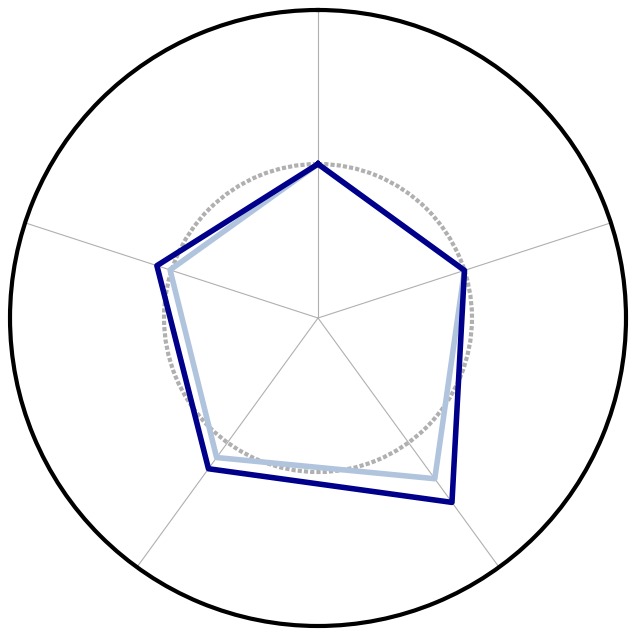

In [29]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

if data == 'fb':
    colors = ['salmon', 'darkred']
else:
    colors = ['lightsteelblue', 'darkblue']


for i in range(len(datasets)):
    values = performance[datasets[i]].tolist()
    values += values[:1]  
    ax.plot(angles, values, linewidth=4, color=colors[i])

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

ax.set_rlabel_position(0)

if data == 'fb':
    ax.set_ylim(-0.1, 0.1)  
else:
    ax.set_ylim(-0.01, 0.01)

if data == 'fb':
    tick_labels = [-0.2, 0.0, 0.2 ]
else:
    tick_labels = [-0.1, 0.0, 0.1 ]
tick_radii  = [t for t in tick_labels]
ax.set_yticks(tick_radii)
gridlines = ax.yaxis.get_gridlines()
gridlines[0].set_linewidth(0)
gridlines[2].set_linewidth(0)
gridlines[1].set_linewidth(3)
gridlines[1].set_linestyle((0, (1, .5))) 

ax.set_xticklabels([]) 
ax.set_yticklabels([]) 

ax.spines["polar"].set_color("black")
ax.spines["polar"].set_linewidth(3)

if data == 'fb':
    plt.savefig('/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/plots/bcv-performance/bcv_performance_' + data + '.png', bbox_inches='tight')
else:
    plt.savefig('/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/plots/bcv-performance/bcv_performance_' + data + '.png', bbox_inches='tight')

plt.show()

In [55]:
zero_idx

1